<a href="https://colab.research.google.com/github/filipemtz/neuralnets/blob/main/hemorrhage_segmentation_pdi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np

In [ ]:
def plot_big(img, cmap="Greys_r"):
  plt.figure(figsize=(10, 10))
  plt.imshow(img, cmap=cmap)


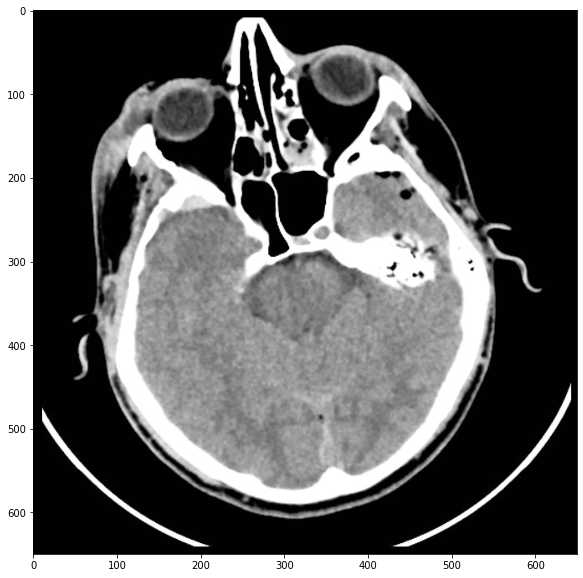

In [ ]:
img = cv2.imread("14.jpg", cv2.IMREAD_GRAYSCALE)
plot_big(img)

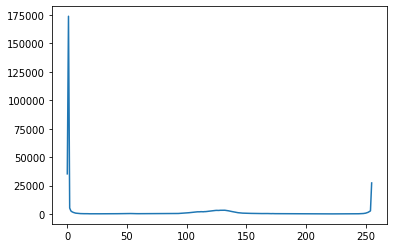

In [ ]:
histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
plt.plot(histogram)

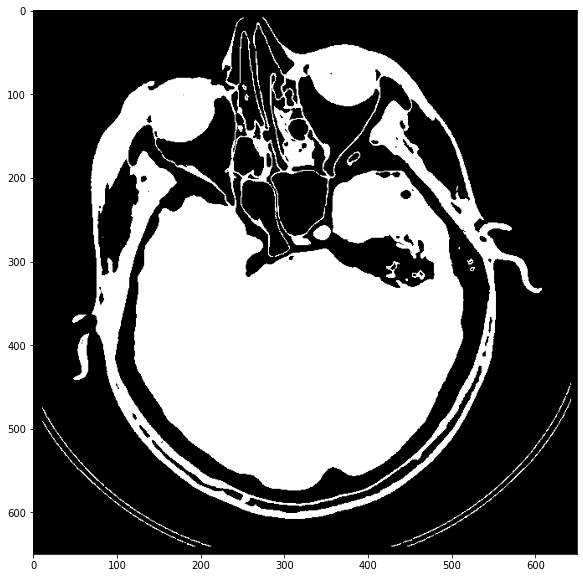

In [ ]:
mask = np.zeros_like(img) + 255
mask[img > 210] = 0
mask[img < 30] = 0

plot_big(mask)

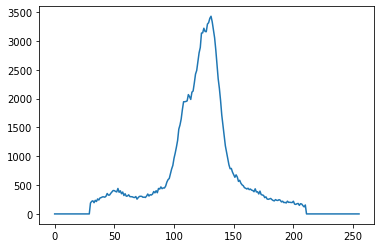

In [ ]:
histogram = cv2.calcHist([img], [0], mask, [256], [0, 256])
plt.plot(histogram)

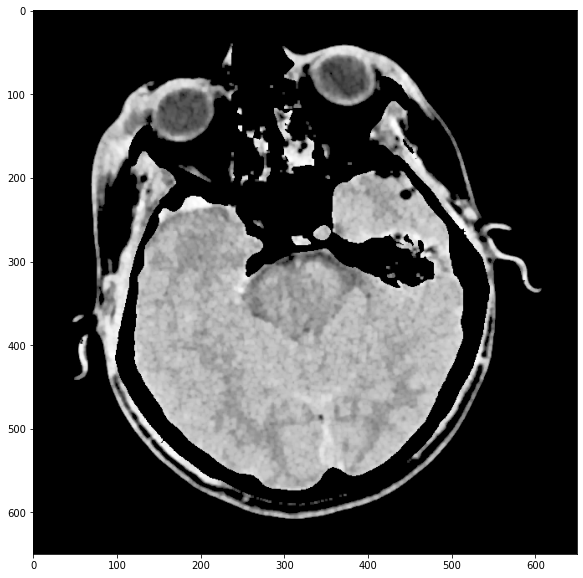

In [ ]:
masked_img = np.copy(img)
masked_img[mask == 0] = 0
masked_img = cv2.erode(masked_img, np.ones((3, 3)))
masked_img = cv2.dilate(masked_img, np.ones((3, 3)))
plot_big(masked_img)

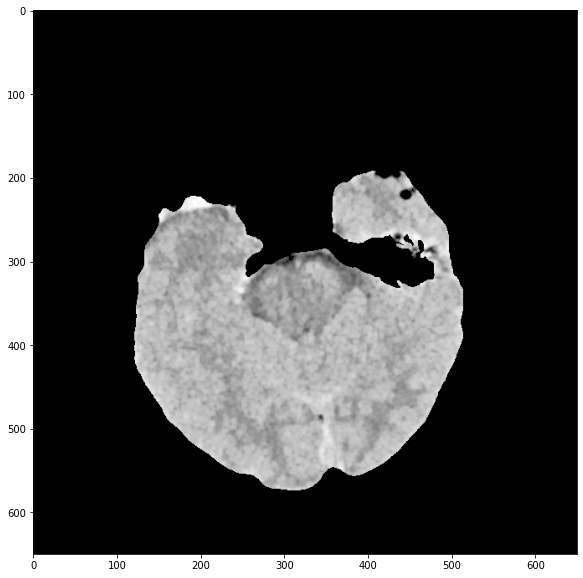

In [ ]:
def biggest_component(image):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    mask = np.zeros(output.shape)
    mask[output == max_label] = 255
    return mask

brain_mask = biggest_component(masked_img)
#brain_mask = cv2.erode(brain_mask, np.ones((5, 5)))
#brain_mask = cv2.dilate(brain_mask, np.ones((5, 5)))
masked_brain = np.copy(masked_img) 
masked_brain[brain_mask == 0] = 0

plot_big(masked_brain)

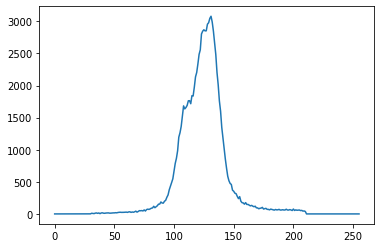

In [ ]:
histogram = cv2.calcHist([img], [0], brain_mask.astype(np.uint8), [256], [0, 256])
plt.plot(histogram)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


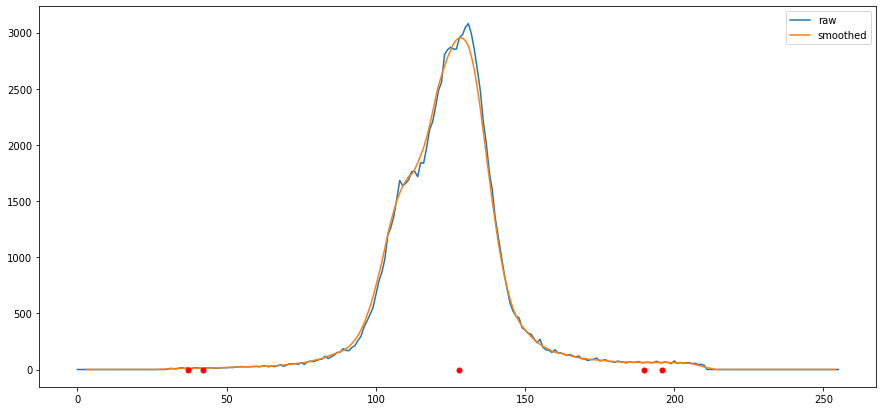

In [ ]:
smoothed_histogram = apply_smoothing(histogram, window_size=9)
maxs = find_extrema_with_windowing(smoothed_histogram, window_size=7, is_min=False)
mins = find_extrema_with_windowing(smoothed_histogram, window_size=7, is_min=True)

plt.figure(figsize=(15, 7))
plt.plot(histogram)
plt.plot(smoothed_histogram)
plt.legend(['raw', 'smoothed'])
plt.plot(maxs, [0] * len(maxs), '.r', markersize=10)
#plt.plot(mins, [0] * len(mins), '.g', markersize=10)


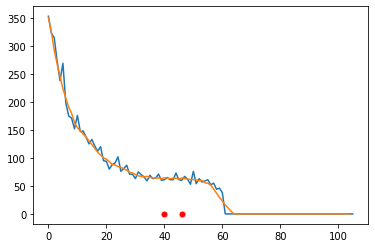

In [ ]:
plt.plot(histogram[150:])
plt.plot(smoothed_histogram[150:])
high_maxs = [m-150 for m in maxs if m > 150]
plt.plot(high_maxs, [0] * len(high_maxs), '.r', markersize=10)

In [ ]:
def find_normal_brain_peaks(smoothed_histogram, maxs):
  normal_maxs = []
  for m in maxs:
    if m > 1500:
      normal_maxs.append(m)
  return normal_maxs


def check_for_hemorrhages(smoothed_histogram, maxs, normal_maxs):
  possible_hemorrhages
  for m in maxs:
    if (m > normal_maxs[-1]):
      pass # para terminar


159 196 233


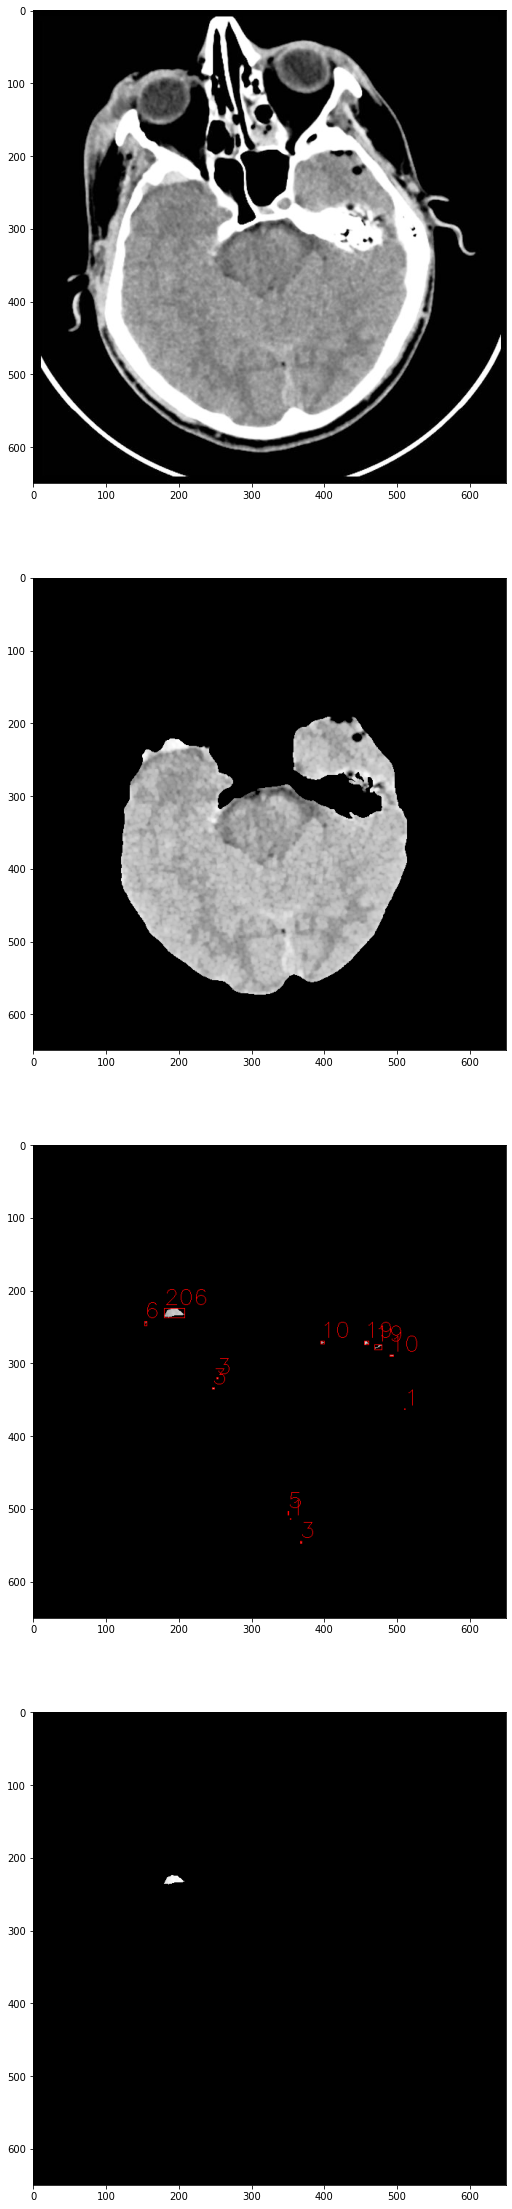

In [ ]:
# find the first maximum after the 150 and assume it is the hemorrhage
hemorrhage_idx = 0
for i, val in enumerate(maxs):
  if val > 150:
    hemorrhage_idx = i
    break

threshold = int(0.5 * maxs[hemorrhage_idx] + 0.5 * maxs[hemorrhage_idx-1])

width = maxs[-1] - threshold
left_limit = maxs[-1] - width
right_limit = maxs[-1] + width
print(left_limit, maxs[-1], right_limit)

mask = np.copy(masked_brain)
mask[mask < left_limit] = 0
mask[mask > right_limit] = 0
mask[mask > 0] = 255

mask = cv2.erode(mask, np.ones((5, 5)))
#mask = cv2.dilate(mask, np.ones((3, 3)), iterations=2)
segmented = np.copy(img)
segmented[mask == 0] = 0

# draw connected components and their areas
output = cv2.connectedComponentsWithStats(mask)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]
components_view = cv2.cvtColor(segmented, cv2.COLOR_GRAY2BGR)
for label_idx in range(1, num_labels): # starts from 1 to ignore backgronud
  bb_left = stats[label_idx, cv2.CC_STAT_LEFT]
  bb_top = stats[label_idx, cv2.CC_STAT_TOP]
  bb_height = stats[label_idx, cv2.CC_STAT_HEIGHT]
  bb_width = stats[label_idx, cv2.CC_STAT_WIDTH]
  bb_area = stats[label_idx, cv2.CC_STAT_AREA]

  cv2.rectangle(components_view, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), (255, 0, 0), 1)
  cv2.putText(components_view, f"{bb_area}", (bb_left, bb_top-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

# assume that small connected components are noise and discard them
def mask_out_small_components(labels, stats, area_threshold=20):
  components_to_keep = []
  for label_idx in range(1, num_labels): # starts from 1 to ignore backgronud
    if stats[label_idx, cv2.CC_STAT_AREA] >= area_threshold:
      components_to_keep.append(label_idx)
    
  mask = np.zeros_like(labels)
  for label_idx in components_to_keep:
    mask[labels == label_idx] = 255
  
  return mask

noise_removal_mask = mask_out_small_components(labels, stats)
mask[noise_removal_mask == 0] = 0
segmented[noise_removal_mask == 0] = 0

plt.figure(figsize=(10, 40))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap="Greys_r")
plt.subplot(4, 1, 2)
plt.imshow(masked_brain, cmap="Greys_r")
plt.subplot(4, 1, 3)
plt.imshow(components_view, cmap="Greys_r")
plt.subplot(4, 1, 4)
plt.imshow(segmented, cmap="Greys_r")


(650, 650) 0 255
(650, 650, 3) 0 255


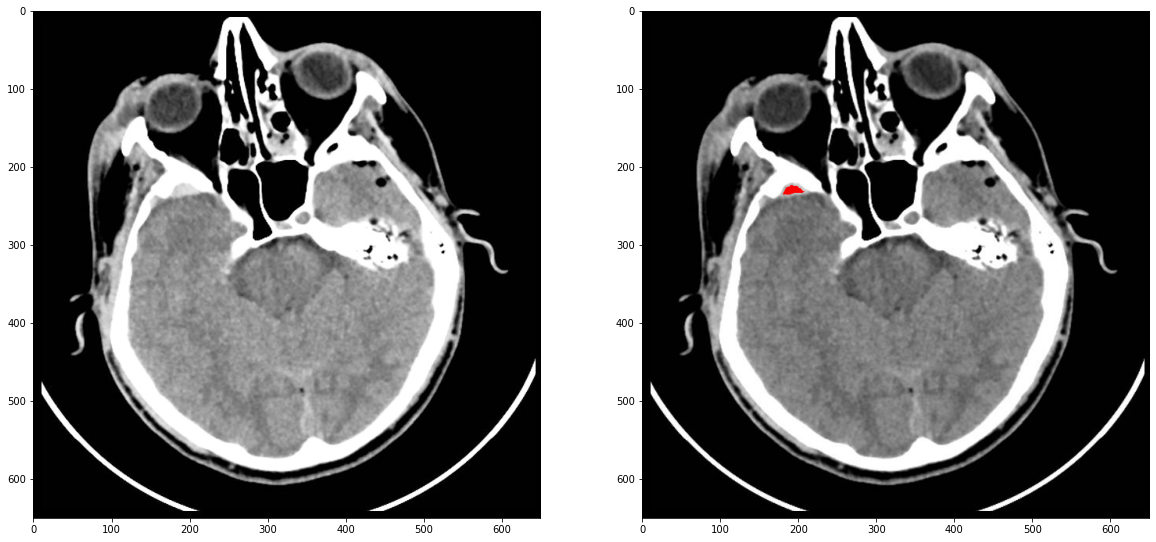

In [ ]:
heatmap = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
heatmap[mask > 0] = (255, 0, 0)

print(mask.shape, np.min(mask), np.max(mask))
print(heatmap.shape, np.min(heatmap), np.max(heatmap))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="Greys_r")
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap="Greys_r")

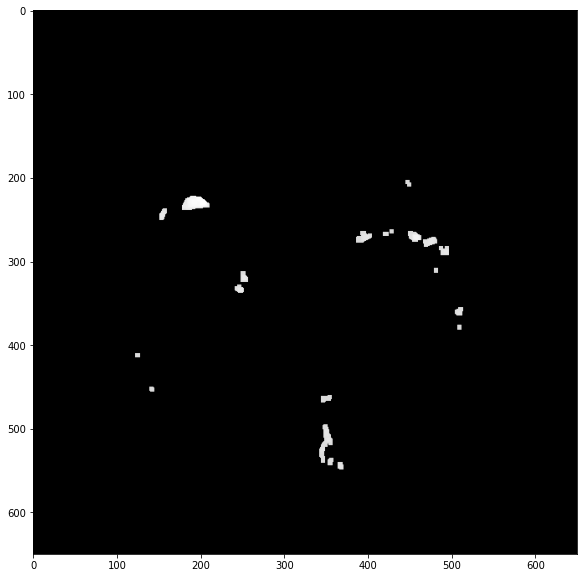

In [ ]:
test = np.copy(masked_brain)
test[test < 150] = 0
test = cv2.erode(test, np.ones((5, 5)))
test = cv2.dilate(test, np.ones((5, 5)))
plot_big(test)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


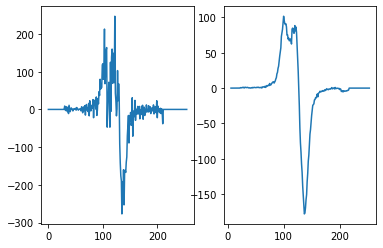

In [ ]:
from scipy.signal import medfilt


def derivate(values):
  derivatives = []
  for i in range(1, len(values)):
    dx = i - (i - 1)
    dy = values[i] - values[i - 1]
    derivatives.append(dy / dx)
  return derivatives

def apply_smoothing(values, window_size=15):
  smoothed = []

  for i in range(1, len(values)):
    l = i - window_size // 2
    r = i + window_size // 2
    window = values[l : r]
    smoothed.append(np.mean(window))

  return smoothed

derivatives = derivate(histogram)
smoothed_derivatives = apply_smoothing(derivatives, window_size=15)

plt.subplot(1, 2, 1)
plt.plot(derivatives)
plt.subplot(1, 2, 2)
plt.plot(smoothed_derivatives)



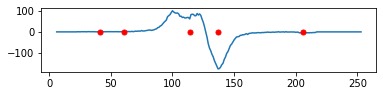

In [ ]:
less_than_fn = lambda x, y: x < y
greater_than_fn = lambda x, y: x > y

def find_extrema_with_windowing(values, window_size=21, is_min=False): 
  arg_fn = np.argmin if is_min else np.argmax
  comp_fn = less_than_fn if is_min else greater_than_fn

  extrema_points = []
  #for idx in range(window_size//2, len(values)-window_size//2):
  for idx in range(len(values)):
    l = idx - window_size // 2
    r = idx + window_size // 2
    window = values[l : r]
    if len(window) <= 1:
      continue
    local_extrema_idx = arg_fn(window)
    if idx == (l + local_extrema_idx):
      avg_before = np.mean(window[:len(window)//2])
      avg_after = np.mean(window[len(window)//2:])
      if comp_fn(values[idx], avg_before) and comp_fn(values[idx], avg_after):
        extrema_points.append(idx)

  return extrema_points


def find_min_points_with_derivatives(values, smooth_derivatives=True): 
  FIRST_THRESHOLD = 1e-1
  SECOND_THRESHOLD = 1e-1

  WINDOW_SIZE = 10

  first_derivatives = derivate(values)
  if smooth_derivatives:
    first_derivatives = apply_smoothing(first_derivatives, window_size=5)
  
  second_derivatives = derivate(first_derivatives)
  if smooth_derivatives:
    second_derivatives = apply_smoothing(second_derivatives, window_size=5)
  
  min_points = []

  for idx in range(len(first_derivatives)):
    l = idx - WINDOW_SIZE // 2
    r = idx + WINDOW_SIZE // 2
    window = np.abs(first_derivatives[l : r])
    if len(window) <= 1:
      continue
    argmin_idx = np.argmin(window)
    if idx == (l + argmin_idx):
      first_d = first_derivatives[idx]
      second_d = second_derivatives[idx]
      if abs(first_d) < FIRST_THRESHOLD and second_d > SECOND_THRESHOLD:
        min_points.append(idx)
      
  return min_points, first_derivatives, second_derivatives


min_points = find_extrema_with_windowing(smoothed_derivatives, is_min=True)

plt.subplot(3, 1, 1)
plt.plot(smoothed_derivatives)
plt.plot(min_points, [0] * len(min_points), '.r', markersize=10)
#plt.subplot(3, 1, 2)
#plt.plot(f)
#plt.subplot(3, 1, 3)
#plt.plot(s)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


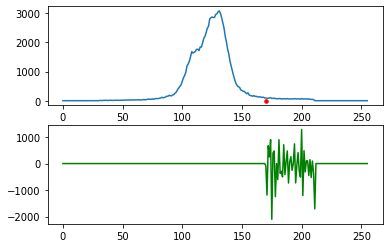

In [ ]:
def find_skull_removal_threshold(histogram):
  max_intensity = 256
  start = int((2 / 3) * 256)
  end = 256
  fxs = []
  theshold = start
  min_fx = np.inf  
  for i in range(start, end):
    dp = histogram[i] - histogram[i - 1]
    di = i - (i - 1)
    d = max_intensity - i
    fx = (dp / di) * d
    if fx > min_fx: 
      min_fx = fx
      threshold = i
    fxs.append(fx)
  return theshold, fxs

threshold, fxs = find_skull_removal_threshold(histogram)

plt.subplot(2, 1, 1)
plt.plot(histogram)
plt.plot([threshold], [0], '.r', markersize=7)
plt.subplot(2, 1, 2)
plt.plot(range(256), ([0] * int(256  - (1/3) * 256)) + list(fxs), '-g')


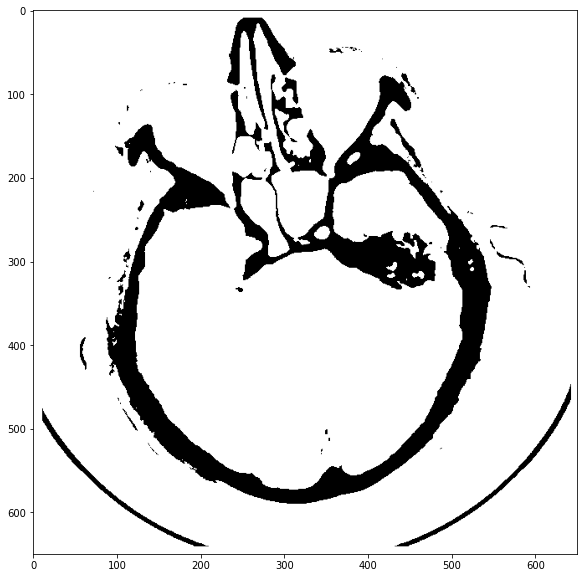

In [ ]:
mask = np.copy(img)
mask[mask <= threshold] = 0 
mask[mask > threshold] = 255
mask = 255 - mask

plot_big(mask)